Maruyama approximation

\begin{equation*}
X_{{n+1}} = X_{n} + a(X_{n}) \Delta t + b(X_{n}) \Delta W_{n}
\end{equation*}

*Bayesian parameter inference for stochastic biochemical network models using particle Markov chain Monte Carlo, Andrew Golightly and Darren J. Wilkinson, (2011)*

Our problem:

\begin{align*}
\tag{1}
& \dot{S} & = & -\lambda S + \frac{P}{di} + \frac{N}{di}&\\ \\
\tag{2}
& \dot{I} & = &  \lambda S - I \frac{1}{wip} - I \frac{1}{dai} &\\ \\
\tag{3}
& \dot{G} & = &  I \frac{1}{wip} - G \frac{1}{dwt} &\\ \\ 
\tag{4}
& \dot{P} & = &  I \frac{psc}{dai} + G \frac{psc}{dwt} - P \frac{1}{di} &\\ \\
\tag{5}
& \dot{N} & = &  I \frac{1-psc}{dai} + G \frac{1-psc}{dwt} - N \frac{1}{di} &\\ \\
\end{align*}

We define:

\begin{equation*}
\mathbf{X} = \begin{bmatrix} S & I & G & P & N \end{bmatrix}^T
\end{equation*}

\begin{equation*}
\mathbf{\theta} = \begin{bmatrix} \lambda & di & wip & dai & dwt & psc \end{bmatrix}^T
\end{equation*}

#### Stoichiometry matrix

\begin{equation*}
A = \begin{bmatrix}
    -1 & 1  & 1  & 0  & 0  & 0  & 0 & 0 & 0  & 0 & 0 \\
    1  & 0  & 0  & -1 & -1 & 0  & 0 & 0 & 0  & 0 & 0 \\
    0  & 0  & 0  & 1  & 0  & -1 & 0 & 0 & 0  & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 1 & 1 & -1 & 0 & 0 \\
    0  & 0  & -1 & 0  & 0  & 0  & 0 & 0 & 0  & 1 & 1 \\
\end{bmatrix}
\end{equation*}

\begin{equation*}
h = \begin{bmatrix}
    \lambda S&
    \frac{P}{di}&
    \frac{N}{di}&
    \frac{I}{wip}&
    \frac{I}{dai}&
    \frac{G}{dwt}&
    I\frac{psc}{dai}&
    G\frac{psc}{dwt}&
    \frac{P}{di}&
    I\frac{1-psc}{dai}&
    G\frac{1-psc}{dwt}
\end{bmatrix}^T
\end{equation*}

#### Drift

\begin{equation*}
\alpha(\mathbf{X}, \mathbf{\theta}) = A \cdot h(\mathbf{X}, \mathbf{\theta})= \begin{bmatrix}
    -\lambda S + \frac{P}{di} + \frac{N}{di} \\
    \lambda S - I \frac{1}{wip} - I \frac{1}{dai} \\
    I \frac{1}{wip} - G \frac{1}{dwt} \\
    I \frac{psc}{dai} + G \frac{psc}{dwt} - P \frac{1}{di} \\
    I \frac{1-psc}{dai} + G \frac{1-psc}{dwt} - N \frac{1}{di}
\end{bmatrix}
\end{equation*}

#### Diffusion

\begin{equation*}
\beta(\mathbf{X}, \mathbf{\theta}) = A \cdot diag(h(\mathbf{X}, \mathbf{\theta})) \cdot A^T = \begin{bmatrix}
    \lambda S + \frac{P}{di} + \frac{N}{di} & -\lambda S & 0 & 0 & -\frac{N}{di} \\
    -\lambda S & \lambda S + \frac{I}{wip} + \frac{I}{dai} & -\frac{I}{wip} & 0 & 0 \\
    0 & -\frac{I}{wip} & \frac{I}{wip} + \frac{G}{dwt} & 0 & 0 \\
    0 & 0 & 0 & I \frac{psc}{dai} + G \frac{psc}{dwt} + \frac{P}{di} & 0 \\
    -\frac{N}{di} & 0 & 0 & 0 & \frac{N}{di} + I \frac{1-psc}{dai} + G \frac{1-psc}{dwt}
\end{bmatrix}
\end{equation*}

In [181]:
def alpha(xt, params):
    S, I, G, P, N = [xt[:,i] for i in range(5)]
    lambda_, di, wip, dai, dwt, psc = params
    
    return tf.concat([
        - lambda_ * S + P / di + N / di,
        lambda_ * S - I / wip - I / dai,
        I / wip - G / dwt,
        I * psc / dai + G * psc / dwt - P / di,
        I * (1-psc) / dai + G * (1-psc) / dwt - N / di
    ], 1)

def beta(xt, params):
    S, I, G, P, N = [xt[:,i] for i in range(5)]
    lambda_, di, wip, dai, dwt, psc = params
    
    a11 = lambda_ * S + P / di + N / di
    a12 = - lambda_ * S
    a13 = tf.zeros_like(S)
    a14 = tf.zeros_like(S)
    a15 = - N / di
    
    a21 = - lambda_ * S
    a22 = lambda_ * S + I / wip + I / dai
    a23 = - I / wip
    a24 = tf.zeros_like(S)
    a25 = tf.zeros_like(S)
    
    a31 = tf.zeros_like(S)
    a32 = - I / wip
    a33 = I / wip + G / dwt
    a34 = tf.zeros_like(S)
    a35 = tf.zeros_like(S)
    
    a41 = tf.zeros_like(S)
    a42 = tf.zeros_like(S)
    a43 = tf.zeros_like(S)
    a44 = I * psc / dai + G * psc / dwt + P / di
    a45 = tf.zeros_like(S)
    
    a51 = - N /di
    a52 = tf.zeros_like(S)
    a53 = tf.zeros_like(S)
    a54 = tf.zeros_like(S)
    a55 = N / di + I * (1-psc) / dai + G * (1-psc) / dwt
    
    # we use Cholesky–Banachiewicz algo to compute the Cholesky matrix
    l11 = tf.sqrt(a11)
    zeros = tf.zeros_like(l11)
    row1 = tf.concat([l11, zeros, zeros, zeros, zeros], 2)
    
    l21 = a21 / l11
    l22 = tf.sqrt(a22 - tf.square(l21))
    row2 = tf.concat([l21, l22, zeros, zeros, zeros], 2)
    
    l31 = a31 / l11
    l32 = (a32 - l31*l21) / l22
    l33 = tf.sqrt(a33 - tf.square(l31) - tf.square(l32))
    row3 = tf.concat([l31, l32, l33, zeros, zeros], 2)
    
    l41 = a41 / l11
    l42 = (a42 - l41*l21) / l22
    l43 = (a43 - l41*l31 - l42*l32) / l33
    l44 = tf.sqrt(a44 - tf.square(l41) - tf.square(l42) - tf.square(l43))
    row4 = tf.concat([l41, l42, l43, l44, zeros], 2)
    
    l51 = a51 / l11
    l52 = (a52 - l51*l21) / l22
    l53 = (a53 - l51*l31 - l52*l32) / l33
    l54 = (a54 - l51*l41 - l52*l42 - l53*l43) / l44
    l55 = tf.sqrt(a55 - tf.square(l51) - tf.square(l52) - tf.square(l53) - tf.square(l54))
    row5 = tf.concat([l51, l52, l53, l54, l55], 2)

    #TODO check dims
    
    return tf.concat([row1, row2, row3, row4, row5], 1)

### ELBO

**Observation likelihood:**
given the paths generated, we want to compute the likelihood of seeing the observation and this for each time step

**ODE likelihood:** we use Euler-Maruyama assuming that $x_{t+1}-x_t \sim \mathcal{N}(\alpha(x, \theta)\Delta t, \beta(x, \theta)\Delta t)$ and compute the likelihood of seeing the $x_{diff} = x_{t+1}-x_{t}$ given the current parameters $\theta$.

$\implies$ we are trying to match this distribution with our $q()$ distribution

**Parameter likelihood:** given the current mean and variance of $\theta$ what is the probability of seeing the current $\theta$

$\implies$ we are trying to match this distribution to the prior distribution put on our parameters

\begin{equation*}
q(\hat{\mu}, \hat{\sigma}|predicted) - ode(\theta|predicted) - 
\end{equation*}

We wish to compute the posterior distribution:

\begin{equation*}
p(\theta, x|y) \propto p(\theta)p(x|\theta)p(y|x, \theta)
\end{equation*}

#### $p(\theta)$

The prior on the parameters.

#### $p(x|\theta)$

We use a classical approach in the Monte Carlo litterature (Golightly & Wilkinson 2008) on SDE and introduce an approximation to the discretised diffusion process conditional on the parameters and observations at a single time. We want to create a path connecting 2 separate observations.

From Itô calculus we have the following:

\begin{equation*}
{\mathrm  {d}}X_{t}=\alpha(X_{t}, \theta)\,{\mathrm  {d}}t+\beta(X_{t}, \theta)\,{\mathrm  {d}}W_{t}
\end{equation*}

We use the Chemical Langevin Equation (CLE) approximation to find $\alpha(\cdot)$ and $\beta(\cdot)$:

\begin{equation*}
{\mathrm  {d}}X_{\tau_i} = A \cdot h(X_{\tau_i}, \theta) {\mathrm  {d}}\tau + A \cdot diag(h(X_{\tau_i}, \theta)) \cdot A^{T} {\mathrm  {d}}W_{\tau}
\end{equation*}

For discretisation of the diffusion we process we use the Euler-Maruyama approximation which consider that the difference between one observation to the next follows a Normal distribution of mean $\alpha(X_{\tau_i}, \theta)\Delta t$ and variance $\beta(X_{\tau_i}, \theta)\Delta t$.

\begin{equation*}
X_{\tau_{i+1}} - X_{\tau_{i}} \sim \mathcal{N}(\alpha(X_{\tau_{i}}, \theta) \Delta \tau, \beta(X_{\tau_{i}}, \theta)\Delta \tau)
\end{equation*}

Thus we have:

\begin{equation*}
\boxed{p(x|\theta) = \prod_{i=0}^{m-1} \varphi(x_{t+1} - x_t, \alpha(x_{\tau_{i}}, \theta)\Delta \tau, \beta(x_{\tau_{i}}, \theta)\Delta \tau)}
\end{equation*}

#### $p(y|x, \theta)$

This is the probability of seeing our observations given the states $x$ and the parameters $\theta$. Golightly & Wilkinson (2008) describe the observation equation as a function of the state equation and some noise:

\begin{equation*}
Y(t) = X(t, \theta) + \varepsilon(t)
\end{equation*}

where $\varepsilon(t) \sim \mathcal{N}(0, \Sigma)$, $\Sigma=diag\{\sigma^2_i\}$ for $i=1,...,d$. Note that for simplicity we will use $\Sigma = \mathbf{I}_d$

We thus have $Y \sim \mathcal{N}(X(\theta), \Sigma)$ and we have the likelihood:

\begin{equation*}
\boxed{p(y|x, \theta) = \prod_{i=0}^{d} \varphi(y_{t_{i}}; \theta, x_{t_{i}}, \Sigma)}
\end{equation*}

#### Approximation

We try to use Variational Approxiation due to performance considerations. That is we are trying to find an approximation $q(\theta; \phi)$ close to the wanted probability $p(\theta|y)$. The objective is to find $\phi$, minimising the Kullback-Liebler divergence between these two probability distributions. As Jordan et al. (1999) has shown, this corresponds at maximising the evidence lower bound:

\begin{equation*}
\mathbb{E}_{q_{\phi}}[\log p(\theta, y) - \log q(\theta; \phi)]
\end{equation*}

In the conctext of ODE we are interested in finding the posterior $q(\theta, x; \phi)$ which is an approximation of our target prior $p(\theta, x | y)$ and can be expressed:

\begin{equation*}
q(\theta, x; \phi) = q(\theta; \phi_{\theta})q(x|\theta; \phi_x)
\end{equation*}

We note that these two factors can be seen as the approximation of $p(\theta)$ and $p(x|\theta)$. In the context of ODE we are thus trying to find two approximattions. One with respect to $\theta$, that is find the $\phi_{\theta}$ that minimises $KL(q(\theta; \phi_{\theta})||p(\theta))$. And another one with respect to $x$ to minimise $KL(q(x|\theta; \phi_x)||p(x|\theta))$. Having these two approximations will help us find the approximation of our posterior $p(\theta, x|y)$.

Finding $q(\theta; \phi_{\theta})$ is rather straightforward, we can use a mean-field approximation for this matter. Note that more complex techniques could be used, but the difficult part of the model lies in the following section so we decide to not spend too much time on this part.

Finding $q(x|\theta; \phi_x)$ is a bit more complex but we can use the same methodology than the one used to find $p(x|\theta)$ whereby we leverage the 

#### Loss function

Our loss function involves multiple components:
- the divergence between $p(\theta)$ and $q(\theta; \phi_{\theta})$
- the divergence between $p(x|\theta)$ and $q(x|\theta; \phi_{x})$
- the likelihood of seeing the data given the current parameter of the system $p(y|x, \theta)$

\begin{equation*}
loss = KL(p(\theta)||q(\theta; \phi_{\theta})) + KL(p(x|\theta)||q(x|\theta; \phi_{x})) +  \mathcal{L}(obs|x, \theta)
\end{equation*}

In [ ]:
def elbo(obs, paths, mu, sigma, params, prior_theta_dist, dt):
    """ELBO method to compute the loss to minimise
    
    Params
    ------
        obs (tf.Tensor(dim=(# samples, # observations))): the observations
        paths (tf.Tensor(dim=(# samples, # states, # observations))): the x path generated 
                from the curve fitting exercise
        mu (tf.Tensor(dim=(# samples, 1))): the mean values of the curve fitting
        sigma (tf.Tensor(dim=(# samples, 1))): the std value of the curve fitting
        params (dict): the dictionary containing the variables params, mean and std
        prior_theta_dist (tfp.Distribution): the prior distribution for theta
        dt (float): the time delta
        
    Returns
    -------
        loss (float): the loss value
    """
    
    # observation likelihood
    obs_logprobs = tf.expand_dims(tf.zeros(1), 1)
    for i in range(obs.shape[-1]):
        obs_dist = tfd.MultivariateNormalDiag(paths[:, :, i])
        obs_logprob = obs_dist.log_prob(obs[:, i])
        obs_logprobs = tf.concat([
            obs_logprobs,
            tf.expand_dims(obs_logprob, 1)
        ], 1)
        
    obs_logprob = tf.reduce_sum(obs_logprob)
        
        
    # ode likelihood
    x_t = paths[:, :, :-1]
    x_t_plus_1 = paths[:, :, 1:]
    
    x_path_diff = x_t_plus_1 - x_t
    x_diff = tf.concat([tf.reshape(x_path_diff[:, i, :], [-1, 1]) 
                        for i in range(x_path_diff.shape[1])], 1)
    
    x_t_param = tf.stack([
        tf.reshape(x_t[:,i,:-1],(-1, 1)) for i in range(x_t.shape[1])
    ], 1)

    alpha_val = alpha(x_t_param, params['value'])
    beta_val = beta(x_t_param, params['value'])

    ## Euler-Maruyama
    ode_dist = tfd.MultivariateNormalTriL(
        loc=dt * alpha_val, 
        scale_tril=tf.sqrt(dt) * beta_val
    )
    ode_logprob = ode_dist.log_prob(x_diff)
    
    
    # q distrib likelihood
    x_path_mean = tf.concat([tf.reshape(x_t[:, i, :], [-1, 1]) 
                            for i in range(x_t.shape[1])], 1)
    x_path_val = tf.concat([tf.reshape(x_t_plus_1[:, i, :], [-1, 1]) 
                            for i in range(x_t_plus_1.shape[1])], 1)

    ## Euler-Maruyama
    q_dist_x = tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=x_path_mean + dt * mu, 
            scale_tril=tf.sqrt(dt) * sigma
        ), 
        bijector=tfb.Softplus()
    )

    q_logprob_x = q_dist_x.log_prob(x_path_val)
    
    kl_x = tf.reduce_sum(tf.reshape(ode_logprob - q_logprob_x, [paths.shape[0], -1]), 1)
    
    # theta likelihood
    theta_val = tf.concat(params['value'], 1)

    q_theta_dist = tfd.MultivariateNormalDiag(
        loc=params['mu'],
        scale_diag=params['sigma']
    )

    prior_theta_loglik = prior_theta_dist.log_prob(theta_val)
    q_theta_loglik = q_theta_dist.log_prob(theta_val)
    kl_theta = prior_theta_loglik - q_theta_loglik
    
    # loss
    loss = - (kl_x + kl_theta + obs_logprob) # we want to maximise the ELBO
    mean_loss = tf.reduce_mean(loss, 0)
    
    return mean_loss

----

TODO: 

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [185]:
data

array([2.80104117, 2.06760356, 1.71678728, 1.519752  , 1.41148181,
       1.29857278, 1.27016041, 1.22695974, 1.17189095, 1.16614779,
       1.12695298, 1.1012704 , 1.05749356, 1.03615041, 1.00607013,
       0.99874352, 0.98238381, 1.00281176, 0.96565932, 0.99254011,
       0.96176698, 0.95434694, 0.97069245, 0.94877561, 0.95226573,
       0.95195953, 0.94064689, 0.95527826, 0.93799316, 0.94497026,
       0.98362845, 0.91061173, 0.94652162, 0.95570852, 0.9348896 ,
       0.92749876, 0.90598237, 0.9178948 , 0.93248146, 0.93212938,
       0.89558187, 0.95192011, 0.91844298, 0.97379033, 0.93604319,
       0.95376289, 0.91205494, 0.93994464, 0.93984213, 0.90327863,
       0.94603579, 0.91564944, 0.9364877 , 0.91708708, 0.9367608 ,
       0.93480819, 0.92543156, 0.91513496, 0.92454856, 0.9107423 ,
       0.92889546, 0.93827121, 0.94129805, 0.93547443, 0.91507036,
       0.93925102, 0.92939488, 0.93963748, 0.94736802, 0.89803601,
       0.91210008, 0.94996609, 0.91881743, 0.93845888, 0.95542

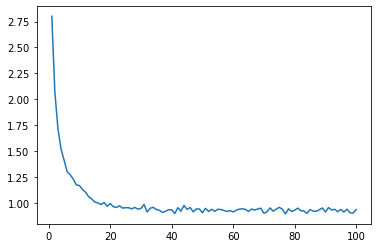

In [190]:
t = np.linspace(0, 100, 101)
plt.plot(t[1:], data)

In [39]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)

yhat = model(x_test)